In [210]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [211]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [212]:
NUM_CLASSES = 26

# 学習データ読み込み

In [213]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [214]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [216]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [217]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_20 (Dropout)        (None, 42)                0         
                                                                 
 dense_30 (Dense)            (None, 20)                860       
                                                                 
 dropout_21 (Dropout)        (None, 20)                0         
                                                                 
 dense_31 (Dense)            (None, 10)                210       
                                                                 
 dense_32 (Dense)            (None, 26)                286       
                                                                 
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0
_________________________________________________________________


In [218]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [219]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [220]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
86/96 [=========================>....] - ETA: 0s - loss: 3.2156 - accuracy: 0.0636
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
96/96 [==============================] - 1s 6ms/step - loss: 3.2050 - accuracy: 0.0668 - val_loss: 3.0601 - val_accuracy: 0.0752
Epoch 2/1000
84/96 [=========================>....] - ETA: 0s - loss: 2.9854 - accuracy: 0.1337
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
96/96 [==============================] - 0s 4ms/step - loss: 2.9672 - accuracy: 0.1390 - val_loss: 2.7371 - val_accuracy: 0.2468
Epoch 3/1000
79/96 [=======================>......] - ETA: 0s - loss: 2.7334 - accuracy: 0.1878
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
96/96 [==============================] - 0s 4ms/step - loss: 2.7071 - accuracy: 0.1926 - val_loss: 2.3911 - val_accuracy: 0.3192
Epoch 4/1000
87/96 [==========================>...] - ETA: 0s - loss: 2.4379 - accuracy: 0.2359
E

In [221]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

32/32 [==============================] - 0s 1ms/step - loss: 0.5416 - accuracy: 0.8272


In [222]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [223]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 50ms/step
[6.4749140e-03 2.2334011e-02 8.9024771e-03 1.1708190e-03 1.2529010e-03
 1.7486913e-03 2.2860736e-02 1.6824475e-02 7.9855067e-04 9.4990749e-10
 5.7589919e-08 1.6363014e-03 5.5493612e-04 2.7125055e-02 5.0159900e-07
 2.2309499e-14 1.7136039e-03 8.2669863e-03 5.8018611e-07 9.4424486e-09
 2.1580002e-15 6.2361340e-07 1.8279414e-09 8.7815624e-01 3.3414181e-05
 1.4411892e-04]
23


# 混同行列

128/128 [==============================] - 0s 1ms/step


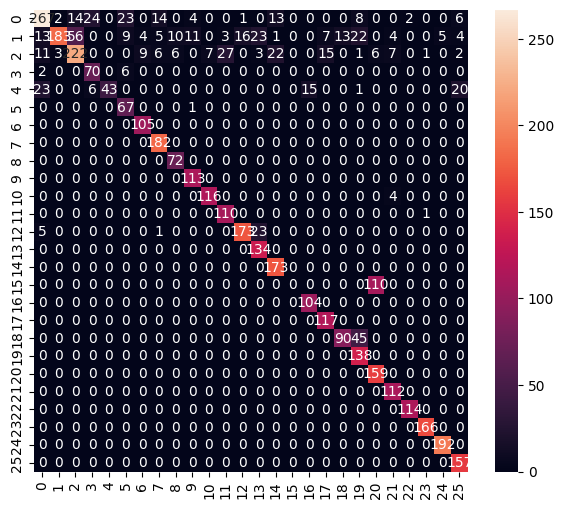

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.71      0.76       378
           1       0.97      0.47      0.63       389
           2       0.76      0.64      0.69       348
           3       0.70      0.90      0.79        78
           4       1.00      0.40      0.57       108
           5       0.64      0.99      0.77        68
           6       0.89      1.00      0.94       105
           7       0.88      1.00      0.93       182
           8       0.82      1.00      0.90        72
           9       0.88      1.00      0.93       113
          10       0.94      0.97      0.95       120
          11       0.79      0.99      0.88       111
          12       0.91      0.86      0.88       202
          13       0.73      1.00      0.85       134
          14       0.83      1.00      0.91       173
          15       0.00      0.00      0.00       110
          16       0.87      1.00      0.93       104
     

d:\Code\ASL-detection\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Code\ASL-detection\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Code\ASL-detection\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [224]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [225]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [226]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ronil\AppData\Local\Temp\tmpinqa7c1c\assets


INFO:tensorflow:Assets written to: C:\Users\ronil\AppData\Local\Temp\tmpinqa7c1c\assets


7592

# 推論テスト

In [227]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [228]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [229]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [230]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [231]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.4749150e-03 2.2334013e-02 8.9024743e-03 1.1708193e-03 1.2529019e-03
 1.7486913e-03 2.2860734e-02 1.6824475e-02 7.9855038e-04 9.4990571e-10
 5.7590036e-08 1.6362985e-03 5.5493618e-04 2.7125038e-02 5.0159861e-07
 2.2309503e-14 1.7136041e-03 8.2669863e-03 5.8018674e-07 9.4424504e-09
 2.1580005e-15 6.2361408e-07 1.8279415e-09 8.7815636e-01 3.3414213e-05
 1.4411910e-04]
23
